In [75]:
%load_ext nb_black
%load_ext lab_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


<IPython.core.display.Javascript object>

This is my project for computational intelligence based on kaggle dataset of monkeys.

In [1]:
# Import packages

import os
from pathlib import Path

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.utils import np_utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.layers import (
    Conv2D,
    Activation,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense,
)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

Set data folders

In [2]:
data_folder = "data"
training_directory = os.path.join(data_folder, "training", "training")
test_directory = os.path.join(data_folder, "validation", "validation")
labels_file = os.path.join(data_folder, "monkey_labels.txt")

Read labels

In [4]:
labels_df = pd.read_csv(labels_file)
labels_df = labels_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
labels_df.columns = labels_df.columns.str.strip()
labels = labels_df["Common Name"]

Read images from files

In [5]:
def convert_image_to_vector(input_image, size=(150, 150)):
    resized_image = cv2.resize(input_image, size)
    return resized_image


def convert_image_to_vector_rgb(input_image, size=(150, 150)):
    resized_image = cv2.resize(input_image, size)
    img_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb


def convert_image_to_vector_cubic(input_image, size=(150, 150)):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    return resized_image


def convert_image_to_vector_both(input_image, size=(150, 150)):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    img_rgb_cubic = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb_cubic


def normalize(input_image):
    mean, std = input_image.mean(), input_image.std()
    input_image = (input_image - mean) / std
    return input_image


def process_image(file):
    image_file = cv2.imread(file)
    image_pixels = convert_image_to_vector_both(image_file, size=(150, 150))
    image_pixels = normalize(image_pixels)
    image_label = file.split(os.path.sep)[-2]
    return image_pixels, image_label

In [6]:
training_images = []
training_images_flattened = []
training_labels = []

for path in Path(training_directory).rglob("*.jpg"):
     image, label = process_image(str(path))
     training_images.append(image)
     training_images_flattened.append(image.flatten())
     training_labels.append(label)

test_images = []
test_images_flattened = []
test_labels = []

for path in Path(test_directory).rglob("*.jpg"):
     image, label = process_image(str(path))
     test_images.append(image)
     test_labels.append(label)
     test_images_flattened.append(image.flatten())


0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object


c:\programowanko\computational-intelligence\project2\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


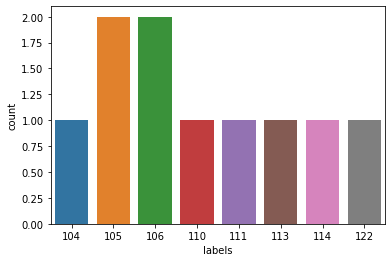

In [7]:
df = pd.DataFrame()
df["labels"]=training_labels
lab = df["labels"]
counts = lab.value_counts()
sns.countplot(counts)
print(labels)

In [8]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_images_knn = np.array(test_images_flattened)

training_images = np.array(training_images)
training_labels = np.array(training_labels)
training_images_knn = np.array(training_images_flattened)

num_classes = len(np.unique(training_labels))
label_encoder = LabelEncoder()
training_labels = label_encoder.fit_transform(training_labels)
test_labels = label_encoder.fit_transform(test_labels)
test_labels = np_utils.to_categorical(test_labels, num_classes)
training_labels = np_utils.to_categorical(training_labels, num_classes)


In [9]:
# LINEAR REGRESSION

lin_reg = LinearRegression()
lin_reg.fit(training_images_flattened, training_labels)
predictions = lin_reg.predict(test_images_flattened)

plt.scatter(training_images_flattened, training_labels,  color='black')
plt.plot(test_images_flattened, test_labels, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

LinAlgError: SVD did not converge in Linear Least Squares

In [84]:
# TEST KNN classifier
model7 = KNeighborsClassifier(n_neighbors=7)
model14 = KNeighborsClassifier(n_neighbors=14)
model2 = KNeighborsClassifier(n_neighbors=2)
model1 = KNeighborsClassifier(n_neighbors=1)

model1.fit(training_images_knn, training_labels)
model2.fit(training_images_knn, training_labels)
model7.fit(training_images_knn, training_labels)
model14.fit(training_images_knn, training_labels)

acc1 = model1.score(test_images_knn, test_labels)
acc2 = model2.score(test_images_knn, test_labels)
acc7 = model7.score(test_images_knn, test_labels)
acc14 = model14.score(test_images_knn, test_labels)

print("Accuracy: {:.2f}%".format(acc1 * 100))
print("Accuracy: {:.2f}%".format(acc2 * 100))
print("Accuracy: {:.2f}%".format(acc7 * 100))
print("Accuracy: {:.2f}%".format(acc14 * 100))


[INFO] histogram accuracy: 18.01%


<IPython.core.display.Javascript object>

In [86]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_28 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_29 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 36, 36, 64)       

<IPython.core.display.Javascript object>

In [87]:
es = EarlyStopping(
    monitor="loss",
    mode="min",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    "Best_model.h5",
    save_best_only=True,
    monitor = "loss",
    mode="min"
)

reduce_lr = ReduceLROnPlateau(
    monitor = "loss",
    factor = 0.3,
    patience = 3,
    min_lr = 1e-5,
    mode = "min",
    verbose = 1
)

model.fit(
    training_images,
    training_labels,
    epochs=30,
    callbacks=[checkpoint_cb, es, reduce_lr]
)
model.save("Model15015032firstsimple"+".h5")

Epoch 1/30
35/35 [==============================] - 19s 517ms/step - loss: 2.3702 - accuracy: 0.1609

<IPython.core.display.Javascript object>

Test accuracy

In [88]:
test_loss, test_acc = model.evaluate(
    test_images,
    test_labels,
    verbose=2
)
print("\nTest accuracy:", test_acc)

9/9 - 1s - loss: 1.8917 - accuracy: 0.6581

Test accuracy: 0.658088207244873


<IPython.core.display.Javascript object>

Test on one image

In [89]:
n = 200
test_image = test_images[n]
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image, batch_size=1)
print(labels[np.argmax(prediction)])
print(labels)

common_squirrel_monkey
0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object


<IPython.core.display.Javascript object>

In [90]:
IMG_SIZE = 150
size = (IMG_SIZE,IMG_SIZE)

datagenerator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest",
    validation_split=0.2
)

train_set = datagenerator.flow_from_directory(
    training_directory,
    target_size = size,
    batch_size=32,
    seed = 42,
    subset="training",
    shuffle = True,
    class_mode="categorical"
)

val_set = datagenerator.flow_from_directory(
    training_directory,
    target_size = size,
    batch_size=32,
    seed = 42,
    subset="validation",
    shuffle = True,
    class_mode="categorical"
)


test_set = datagenerator.flow_from_directory(
    test_directory,
    target_size = size,
    batch_size = 32,
    seed = 42,
    class_mode = "categorical",
    shuffle = False
)

from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB3

Found 881 images belonging to 10 classes.
Found 217 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


<IPython.core.display.Javascript object>

In [91]:
image_generator_model = Sequential()
image_generator_model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = "imagenet"))
image_generator_model.add(GlobalAveragePooling2D())
image_generator_model.add(Flatten())
image_generator_model.add(Dense(512, activation = "relu", bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
image_generator_model.add(Dropout(0.7))
image_generator_model.add(Dense(10, activation = "softmax"))

image_generator_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 5, 5, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               786944    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                5130      
Total params: 11,575,609
Trainable params: 11,488,306
Non-trainable params: 87,303
_____________________________________

<IPython.core.display.Javascript object>

In [92]:
keras.utils.plot_model(image_generator_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


<IPython.core.display.Javascript object>

In [94]:
EPOCHS = 30
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

image_generator_model.compile(
    optimizer = "adam",
    loss ="categorical_crossentropy",
    metrics = ["acc"]
)


image_generator_model.fit(
    train_set,
    validation_data = val_set,
    epochs= EPOCHS,
    batch_size = 32,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VALID,
    callbacks=[es, reduce_lr]
)
print(image_generator_model.evaluate(test_set))
image_generator_model.save("Model15015032second"+".h5")

Epoch 1/30
27/27 [==============================] - 220s 7s/step - loss: 2.0400 - acc: 0.2975 - val_loss: 1.7199 - val_acc: 0.6094

<IPython.core.display.Javascript object>

In [96]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(training_directory,
                                                    target_size=(150, 150),
                                                    batch_size= 64,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_directory,
                                                  target_size=(150, 150),
                                                  batch_size=64,
                                                  seed=1,
                                                  shuffle=False,
                                                  class_mode="categorical")

train_num = train_generator.samples
validation_num = validation_generator.samples

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


<IPython.core.display.Javascript object>

In [97]:
num_classes = 10

monkey_model = Sequential()
monkey_model.add(Conv2D(32,(3,3), input_shape=(150,150,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Conv2D(32,(3,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Conv2D(64,(3,3), padding="same", activation="relu"))
monkey_model.add(Conv2D(64,(3,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Dropout(0.25))
monkey_model.add(Flatten())
monkey_model.add(Dense(512))
monkey_model.add(Activation("relu"))
monkey_model.add(Dropout(0.5))
monkey_model.add(Dense(num_classes))
monkey_model.add(Activation("softmax"))

<IPython.core.display.Javascript object>

In [98]:
monkey_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)
monkey_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 36, 36, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 64)      

<IPython.core.display.Javascript object>

In [101]:
callbacks_list = [es, reduce_lr]
batch_size = 64

monkey_model.fit(
    train_generator,
    steps_per_epoch = train_num // batch_size,
    epochs = 50,
    validation_data = train_generator,
    validation_steps = validation_num // batch_size,
    callbacks = callbacks_list,
    verbose = 1
)
monkey_model.save("Model15015032third"+".h5")

Epoch 1/50
17/17 [==============================] - 42s 2s/step - loss: 0.7563 - acc: 0.7118 - val_loss: 0.7348 - val_acc: 0.7266

<IPython.core.display.Javascript object>

In [ ]:
monkey_model.evaluate(validation_generator)